# Recreating the Davette Application (Section 11.4)

This notebook reads the data from `davette_data.csv`, runs OLS for Equation (2), computes $\widehat{E}[Y\mid X]$, defines and evaluates the expected-profit function, and finds the optimal $X\le 52$ that maximizes expected profits.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in the data
df = pd.read_csv("davette_data.csv")
df.head(10)

,X,Y
0,12,4120
1,14,4220
2,16,4947
3,10,3949
4,14,4584
5,20,5528
6,16,4708
7,14,4255
8,10,3977
9,20,5059


## Estimate Equation (2) by OLS:

$E(Y\mid X) = \alpha_0 + \alpha_1 X$

In [5]:
# Prepare X with an intercept
X = sm.add_constant(df['X'])   # adds a column of 1's for the intercept
Y = df['Y']

# Fit the OLS model
model = sm.OLS(Y, X)
results = model.fit()
# results.summary()

Let’s pull out the estimated coefficients explicitly:

In [6]:
alpha0_hat = results.params['const']
alpha1_hat = results.params['X']

print(f"\u03B1_0 (intercept) = {alpha0_hat:.3f}")
print(f"\u03B1_1 (slope on X) = {alpha1_hat:.3f}")

α_0 (intercept) = 2502.604
α_1 (slope on X) = 135.062


## Compute $\widehat{E}[Y\mid X]$

For each observed `X`, we form:
$\widehat{Y}(X) = \widehat\alpha_0 + \widehat\alpha_1 X$.
We’ll add this as a new column in `df`.

In [7]:
df['Y_hat'] = alpha0_hat + alpha1_hat * df['X']
df.head(10)

,X,Y,Y_hat
0,12,4120,4123.343938
1,14,4220,4393.467273
2,16,4947,4663.590609
3,10,3949,3853.220602
4,14,4584,4393.467273
5,20,5528,5203.837281
6,16,4708,4663.590609
7,14,4255,4393.467273
8,10,3977,3853.220602
9,20,5059,5203.837281


## 5️⃣ Define and plot the expected-profit function

$E[\text{Profit}](X) = (40 - 15) E[Y\mid X] - 1700 X = 25 (\widehat\alpha_0 + \widehat\alpha_1 X) - 1700 X.$

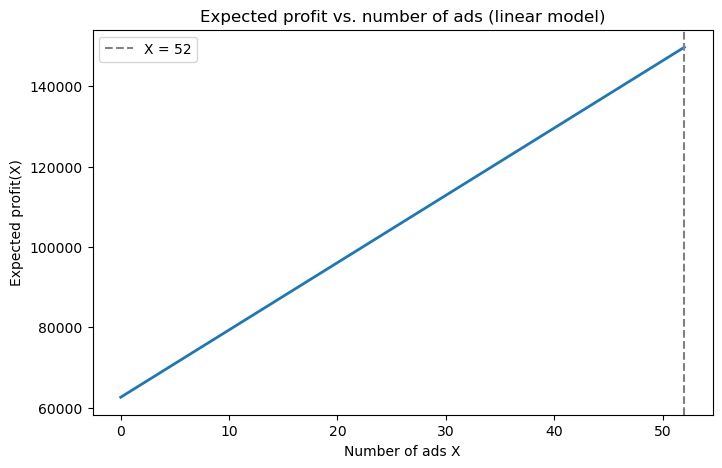

In [8]:
# Define the expected-profit function (continuous X allowed)
def expected_profit(x, alpha0, alpha1):
    """
    Returns E[Profit](X) = 25*(alpha0 + alpha1*x) - 1700*x
    """
    return 25*(alpha0 + alpha1*x) - 1700*x

# Plot it for X in [0, 52]:
X_grid = np.linspace(0, 52, 501)   # 501 points equally spaced from 0 to 52
profit_grid = expected_profit(X_grid, alpha0_hat, alpha1_hat)

plt.figure(figsize=(8,5))
plt.plot(X_grid, profit_grid, lw=2)
plt.axvline(52, color='gray', linestyle='--', label='X = 52')
plt.xlabel('Number of ads X')
plt.ylabel('Expected profit(X)')
plt.title('Expected profit vs. number of ads (linear model)')
plt.legend();

Because the slope term $(25 \widehat\alpha_1 - 1700)$ will turn out to be positive (see coefficients),
the linear-in-$X$ function is increasing on [0, 52]. Hence the maximum in [0, 52] is attained at $X = 52$.

## 6️⃣ Find the optimal $X\le 52$

Since $E[\text{Profit}](X)$ is affine in $X$, if the coefficient on $X$ is > 0, the unconstrained optimum is at $X = 52$.  We can verify explicitly over our grid.

In [9]:
# Find index of the maximal profit on our grid
i_max = np.argmax(profit_grid)
X_opt_grid = X_grid[i_max]
max_profit = profit_grid[i_max]

print(f"Optimal X on [0,52] (grid) = {X_opt_grid:.2f}")
print(f"E[Profit] at X_opt = ${max_profit:,.2f}")

Optimal X on [0,52] (grid) = 52.00
E[Profit] at X_opt = $149,745.27


=====  Equation (3) OLS Results  =====
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     594.8
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           4.72e-23
Time:                        09:54:37   Log-Likelihood:                -194.72
No. Observations:                  30   AIC:                             395.4
Df Residuals:                      27   BIC:                             399.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2

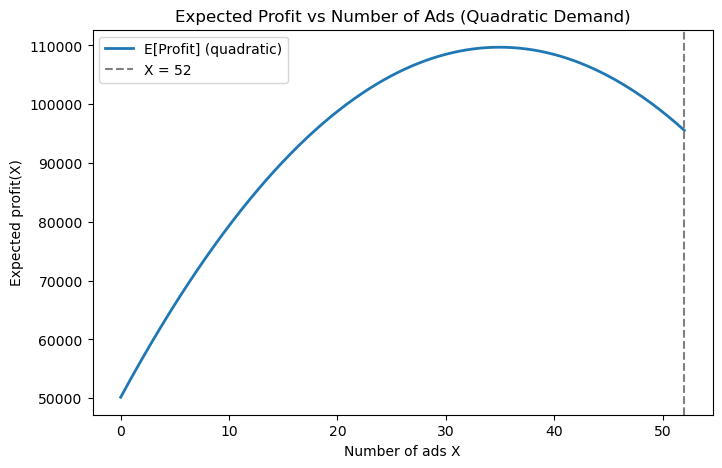


Optimal X on [0, 52] (grid search) = 34.94
E[Profit] at that X = $109,692.34
E[Profit] at X = 52: $95,552.52


In [13]:
# Create X^2 and re‐run OLS for Equation (3)
df['X2'] = df['X']**2

# Build the design matrix [const, X, X2]
X_quad = df[['X', 'X2']]
X_quad = sm.add_constant(X_quad)   # adds the intercept column

# Dependent variable
Y = df['Y']

# Fit the quadratic model
model_q = sm.OLS(Y, X_quad)
results_q = model_q.fit()
print("=====  Equation (3) OLS Results  =====")
print(results_q.summary())

# Extract estimated coefficients
alpha0_hat_q = results_q.params['const']
alpha1_hat_q = results_q.params['X']
alpha2_hat_q = results_q.params['X2']
print(f"\nα₀_hat = {alpha0_hat_q:.3f}")
print(f"α₁_hat = {alpha1_hat_q:.3f}")
print(f"α₂_hat = {alpha2_hat_q:.6f}")

# Compute Ŷ(X) = α₀ + α₁ X + α₂ X^2 for each observed X
df['Y_hat_q'] = alpha0_hat_q + alpha1_hat_q * df['X'] + alpha2_hat_q * df['X']**2
df.head(10)

# Define the new expected‐profit function (quadratic in X)
def expected_profit_q(x, a0, a1, a2):
    """
    E[Profit](X) = 25*(a0 + a1*x + a2*x^2) - 1700*x
    """
    return 25*(a0 + a1*x + a2*(x**2)) - 1700*x

# Plot E[Profit]_quad for x in [0, 52]
X_grid_q = np.linspace(0, 52, 501)
profit_grid_q = expected_profit_q(X_grid_q, alpha0_hat_q, alpha1_hat_q, alpha2_hat_q)

plt.figure(figsize=(8,5))
plt.plot(X_grid_q, profit_grid_q, lw=2, label='E[Profit] (quadratic)')
plt.axvline(52, color='gray', linestyle='--', label='X = 52')
plt.xlabel('Number of ads X')
plt.ylabel('Expected profit(X)')
plt.title('Expected Profit vs Number of Ads (Quadratic Demand)')
plt.legend()
plt.show()

# Search for the optimal X in [0, 52]
i_max_q = np.argmax(profit_grid_q)
X_opt_grid_q = X_grid_q[i_max_q]
max_profit_q = profit_grid_q[i_max_q]

print(f"\nOptimal X on [0, 52] (grid search) = {X_opt_grid_q:.2f}")
print(f"E[Profit] at that X = ${max_profit_q:,.2f}")
print(f"E[Profit] at X = 52: ${expected_profit_q(52, alpha0_hat_q, alpha1_hat_q, alpha2_hat_q):,.2f}")
